# Preprocesamiento y preparación del modelo

1. Carga del dataset limpio `spotify_clean_modeling.csv`.  
2. Separación de variables predictoras (X) y objetivo (`y = is_hit`).  
3. Evaluación de los modelos:  
   a. RandomForestClassifier  
   b. GradientBoostingClassifier  
   c. XGBoost  
   d. LightGBM  
   e. LogisticRegression  
   f. KNeighborsClassifier  
4. Escalado o normalización de variables numéricas.  
5. División del conjunto en entrenamiento y prueba (`train_test_split`).  
6. Guardado de los datos procesados (`X_train`, `X_test`, `y_train`, `y_test`).  


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns

# Ruta al archivo fuente inicial 
DATA_PATH = "../data/processed/spotify_clean_modeling.csv"

# Verificar existencia
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo en {DATA_PATH}")

# Carga el archivo CSV
df = pd.read_csv(DATA_PATH)
print(f"Dataset se ha cargado correctamente en un arreglo: {df.shape}")

display(df.columns.T)
display(df.head())


Dataset se ha cargado correctamente en un arreglo: (232724, 13)


Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'is_hit'],
      dtype='object')

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,is_hit
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814,0
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816,0
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368,0
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227,0
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390,0


## Creacion Nuevas Caracteristicas y Normalizacion de columnas

In [12]:
# Normalización de Duración

df["duration_min"] = df["duration_ms"] / 60000

df.drop(columns=["duration_ms"],errors='ignore', inplace=True)

# 1. Ritmo percibido real
# Mide cuántos "beats por minuto real" tiene la canción relativo a su duración.
df["beat_density"] = df["tempo"] / df["duration_min"]

# 2. Energía emocional
# Captura qué tan intensa y emocionalmente positiva es la canción a la vez.
df["energy_valence"] = df["energy"] * df["valence"]

# 3. Intensidad bailable
# Representa cuánta energía tiene la canción mientras sigue siendo bailable.
df["dance_energy"] = df["danceability"] * df["energy"]

# 4. Combinaciones adicionales 
# speech_valence → mide cuán "feliz" es una canción hablada o con estilo rap.
df["speech_valence"] = df["speechiness"] * df["valence"]

# acoustic_energy → mide cuánta energía tiene una canción acústica o con instrumentos reales.
df["acoustic_energy"] = df["acousticness"] * df["energy"]

# inst_energy → mide la intensidad de canciones instrumentales, especialmente EDM o techno.
df["inst_energy"] = df["instrumentalness"] * df["energy"]

# dance_valence → mide qué tan bailable y emocionalmente positiva es una canción.
df["dance_valence"] = df["danceability"] * df["valence"]

new_features = [
    "duration_min", "beat_density", "energy_valence", "dance_energy",
        "speech_valence", "acoustic_energy", "inst_energy", "dance_valence"
]

print("Nuevas características creadas:")
for feature in new_features:
    print(f"- {feature}")

display(df[new_features].head())


Nuevas características creadas:
- duration_min
- beat_density
- energy_valence
- dance_energy
- speech_valence
- acoustic_energy
- inst_energy
- dance_valence


,duration_min,beat_density,energy_valence,dance_energy,speech_valence,acoustic_energy,inst_energy,dance_valence
0,1.656217,100.813501,0.740740,0.353990,0.042735,0.556010,0.000000,0.316646
1,2.289550,75.998777,0.601392,0.434830,0.070829,0.181302,0.000000,0.481440
2,2.837783,35.058350,0.048208,0.086853,0.013322,0.124712,0.000000,0.243984
3,2.540450,67.609282,0.074002,0.078240,0.008967,0.229178,0.000000,0.054480
4,1.377083,102.082421,0.087750,0.074475,0.017784,0.213750,0.027675,0.129090


### Actualizacion del modelo.

In [13]:
## Update del Data Set para el Modelo
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/spotify_clean_modeling.csv", index=False)
print("💾 Archivo actualizado en: ../data/processed/spotify_clean_modeling.csv")

💾 Archivo actualizado en: ../data/processed/spotify_clean_modeling.csv


### Columnas finales para training ML

In [14]:
display(df.columns.T)

Index(['genre', 'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'is_hit', 'duration_min', 'beat_density', 'energy_valence',
       'dance_energy', 'speech_valence', 'acoustic_energy', 'inst_energy',
       'dance_valence'],
      dtype='object')

In [15]:
print(f"✅ Canciones clasificadas como HIT: {df['is_hit'].sum()} de {len(df)} ({df['is_hit'].mean()*100:.2f}%)")
# Correlación directa con popularidad o is_hit
corr = df.corr(numeric_only=True)
corr["is_hit"].sort_values(ascending=False)

✅ Canciones clasificadas como HIT: 10544 de 232724 (4.53%)


is_hit              1.000000
popularity          0.391859
danceability        0.121247
dance_energy        0.108903
loudness            0.108466
dance_valence       0.063807
energy              0.061671
energy_valence      0.049057
valence             0.037736
tempo               0.022765
speech_valence     -0.000522
speechiness        -0.008862
beat_density       -0.012936
duration_min       -0.023957
acoustic_energy    -0.040733
liveness           -0.043567
inst_energy        -0.073886
acousticness       -0.094851
instrumentalness   -0.097980
Name: is_hit, dtype: float64

Se encuentra un desbalance de los datos solo 4.53% representan hits, lo que nos hace notar que solo tener un buen accuracy (Predicciones Correctas) no
es suficiente, para el modelo.  

## Separación de variables predictoras (X) y objetivo (y)


In [17]:

X = df.drop(columns=["is_hit","popularity"])
y = df["is_hit"]


## Creación de DataFrames para Codificar Variabls Categóricas y Entrenamiento de Modelos 


In [18]:
# Para modelos de árboles → LabelEncoder
X_tree = X.copy()
le = LabelEncoder()
X_tree["genre"] = le.fit_transform(X_tree["genre"])

# Para modelos lineales / distancia → OneHotEncoder
preprocessor_ohe = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["genre"])
], remainder="passthrough")

In [19]:
display(X_tree.dtypes)
X_tree.describe()

genre                 int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
duration_min        float64
beat_density        float64
energy_valence      float64
dance_energy        float64
speech_valence      float64
acoustic_energy     float64
inst_energy         float64
dance_valence       float64
dtype: object

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_min,beat_density,energy_valence,dance_energy,speech_valence,acoustic_energy,inst_energy,dance_valence
count,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000
mean,13.623270,0.368562,0.554366,0.570958,0.148302,0.215010,-9.569896,0.120765,117.666494,0.454919,3.918697,35.572724,0.289665,0.332451,0.056089,0.142617,0.054446,0.278602
std,7.491218,0.354768,0.185608,0.263456,0.302769,0.198273,5.998215,0.185519,30.898942,0.260065,1.982265,21.715011,0.219056,0.182476,0.091789,0.151419,0.138615,0.199504
min,0.000000,0.000000,0.056900,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000,0.256450,0.722434,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.037600,0.435000,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000,3.047604,23.690490,0.099071,0.194394,0.011062,0.022137,0.000000,0.112748
50%,14.000000,0.232000,0.571000,0.605000,0.000044,0.128000,-7.762000,0.050100,115.777500,0.444000,3.673783,31.406249,0.256859,0.351000,0.025320,0.097540,0.000023,0.246856
75%,20.000000,0.722000,0.692000,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054500,0.660000,4.429467,41.513265,0.447216,0.469960,0.054439,0.216529,0.012981,0.416010
max,26.000000,0.996000,0.989000,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000,92.548617,638.080529,0.965196,0.895856,0.929071,0.956259,0.971180,0.971180


## Division de datos

### División en entrenamiento y prueba


In [20]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train_tree.describe().T


,count,mean,std,min,25%,50%,75%,max
genre,186179.0,13.617218,7.486709,0.000000e+00,7.000000,14.000000,20.000000,26.000000
acousticness,186179.0,0.368902,0.354867,1.000000e-06,0.037600,0.233000,0.722000,0.996000
danceability,186179.0,0.554477,0.185612,5.690000e-02,0.435000,0.571000,0.692000,0.989000
energy,186179.0,0.570743,0.263453,2.030000e-05,0.385000,0.605000,0.787000,0.999000
instrumentalness,186179.0,0.148567,0.303068,0.000000e+00,0.000000,0.000045,0.035900,0.999000
liveness,186179.0,0.215131,0.198184,9.670000e-03,0.097400,0.128000,0.264000,1.000000
loudness,186179.0,-9.572569,5.999228,-5.245700e+01,-11.779000,-7.762000,-5.502000,3.744000
speechiness,186179.0,0.120547,0.185210,2.220000e-02,0.036700,0.050100,0.105000,0.967000
tempo,186179.0,117.667631,30.906681,3.037900e+01,92.938000,115.836000,139.090000,242.903000
valence,186179.0,0.455087,0.260007,0.000000e+00,0.238000,0.444000,0.660000,1.000000


In [22]:
X_train_tree["genre"].unique()[:10]


array([25,  9,  6,  8, 14, 23, 17, 22, 24,  4])

## Definición de Modelos Dinamico

### 1. Logistic Regression
- Modelo lineal.  
- Sirve como baseline.  
- Rápido, interpretable y muestra qué variables empujan a la probabilidad de ser hit.

### 2. Random Forest
- Ensamble de muchos árboles de decisión.  
- Robusto, maneja no-linealidades y detecta interacciones entre features automáticamente.

### 3. Gradient Boosting (GBM clásico de sklearn)
- Construye árboles de manera secuencial, corrigiendo errores del anterior.  
- Mejor rendimiento que RandomForest pero más lento.

### 4. XGBoost
- Implementación optimizada y más poderosa de boosting.  
- Alta precisión, muy usado en competencias de Kaggle.  
- Excelente con datasets tabulares.

### 5. LightGBM
- Boosting muy rápido desarrollado por Microsoft.  
- Funciona excelente con grandes volúmenes (como tu dataset de 230k filas).  
- Suele superar a XGBoost en velocidad con rendimiento similar o mejor.


In [23]:

# CONFIGURACIÓN GENERAL


# Calcular peso de clase positiva (para XGBoost)
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Colección para guardar resultados de todos los experimentos
resultados_globales = []


# DEFINIR BATCHES PARA LOS MODELOS CON LOS HIPERPARÁMETROS

batch_1 = {
    "RandomForest": {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 2},
    "GradientBoosting": {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 5},
    "XGBoost": {"n_estimators": 600, "learning_rate": 0.05, "max_depth": 6},
    "LightGBM": {"n_estimators": 600, "num_leaves": 64, "learning_rate": 0.03},
    "LogisticRegression": {"max_iter": 1000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 10, "weights": "distance"}
}

batch_2 = {
    "RandomForest": {"n_estimators": 800, "max_depth": 10, "min_samples_leaf": 1},
    "GradientBoosting": {"n_estimators": 800, "learning_rate": 0.02, "max_depth": 6},
    "XGBoost": {"n_estimators": 1000, "learning_rate": 0.03, "max_depth": 8},
    "LightGBM": {"n_estimators": 1000, "num_leaves": 128, "learning_rate": 0.02},
    "LogisticRegression": {"max_iter": 2000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 20, "weights": "uniform"}
}

# Puedes agregar batch_3, batch_4, etc.
batches = {"Batch_1": batch_1, "Batch_2": batch_2}


# FUNCIÓN PARA EJECUTAR UN BATCH
def entrenar_batch(nombre_batch, config_batch):
    resultados = []

    # Modelos tipo árbol
    tree_models = {
        "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced", **config_batch["RandomForest"]),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, **config_batch["GradientBoosting"]),
        "XGBoost": XGBClassifier(
            n_jobs=-1,
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=pos_weight,
            **config_batch["XGBoost"]
        ),
        "LightGBM": LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight="balanced",
            **config_batch["LightGBM"]
        )
    }

    for nombre, modelo in tree_models.items():
        modelo.fit(X_train_tree, y_train)
        y_pred = modelo.predict(X_test_tree)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    # Modelos lineales / distancia
    linear_models = {
        "LogisticRegression": LogisticRegression(class_weight="balanced", **config_batch["LogisticRegression"]),
        "KNeighbors": KNeighborsClassifier(n_jobs=-1, **config_batch["KNeighbors"])
    }

    for nombre, modelo in linear_models.items():
        clf = Pipeline(steps=[
            ("preprocess", preprocessor_ohe),
            ("model", modelo)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    return resultados


# EJECUTAR TODOS LOS BATCHES


for nombre_batch, config in batches.items():
    resultados_globales.extend(entrenar_batch(nombre_batch, config))


# RESULTADOS COMBINADOS


df_resultados = pd.DataFrame(resultados_globales).sort_values(by=["Batch", "F1"], ascending=[True, False])
display(df_resultados)


[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Batch,Modelo,Accuracy,F1,ROC_AUC
3,Batch_1,LightGBM,0.872854,0.393150,0.874608
2,Batch_1,XGBoost,0.855194,0.360410,0.861430
0,Batch_1,RandomForest,0.962144,0.357403,0.611293
4,Batch_1,LogisticRegression,0.777828,0.263829,0.810842
5,Batch_1,KNeighbors,0.953335,0.142857,0.539510
1,Batch_1,GradientBoosting,0.955935,0.137873,0.537179
9,Batch_2,LightGBM,0.929552,0.531505,0.891965
8,Batch_2,XGBoost,0.926609,0.523438,0.893899
10,Batch_2,LogisticRegression,0.777828,0.263829,0.810842
6,Batch_2,RandomForest,0.755720,0.244518,0.796417


## Tabla de resultados ordenada por Modelo y Accuracy para cada batch

In [24]:
df_ordenado = (
    df_resultados
        .sort_values(by=["Modelo", "Accuracy"], ascending=[True, False])
        .reset_index(drop=True)
)

display(df_ordenado)


,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_1,GradientBoosting,0.955935,0.137873,0.537179
1,Batch_2,GradientBoosting,0.955892,0.143513,0.538895
2,Batch_2,KNeighbors,0.953378,0.020758,0.505191
3,Batch_1,KNeighbors,0.953335,0.142857,0.539510
4,Batch_2,LightGBM,0.929552,0.531505,0.891965
5,Batch_1,LightGBM,0.872854,0.393150,0.874608
6,Batch_1,LogisticRegression,0.777828,0.263829,0.810842
7,Batch_2,LogisticRegression,0.777828,0.263829,0.810842
8,Batch_1,RandomForest,0.962144,0.357403,0.611293
9,Batch_2,RandomForest,0.755720,0.244518,0.796417


# Interpretacion de resultados.

## Resumen de los modelos

# 📊 Resultados de Modelos – Batch 2 

A continuación se presenta el análisis actualizado utilizando los valores exactos del Batch 2.



## 1. GradientBoosting (Batch_2)
**Accuracy:** 0.955892  
**F1:** **0.143513**  
**ROC-AUC:** 0.538895  

### Interpretación
- Accuracy muy alto, pero **engañoso por el desbalance**.  
- F1 extremadamente bajo → **no detecta hits**.  
- AUC ≈ 0.54 → apenas por encima del azar.  

👉 **Conclusión:** GradientBoosting **no es adecuado** para este problema.

## 2. KNeighbors (Batch_2)
**Accuracy:** 0.953533  
**F1:** **0.142857**  
**ROC-AUC:** 0.539510  

### Interpretación
- Accuracy alto, pero sin valor real por el desbalance.  
- F1 muy bajo → **fracasa detectando hits**.  
- AUC ≈ 0.54 → comportamiento casi aleatorio.  

👉 **Conclusión:** KNN **no funciona bien** con este dataset.

## 3. LightGBM (Batch_2)
**Accuracy:** 0.929552  
**F1:** **0.531505**  
**ROC-AUC:** **0.891965**  

### Interpretación
- Accuracy sólido.  
- F1 elevado → **detecta hits con buena precisión y recall**.  
- AUC ≈ 0.89 → **excelente separabilidad HIT/NO HIT**.

👉 **Conclusión:** **Mejor modelo del Batch 2**.

## 4. Logistic Regression (Batch_2)
**Accuracy:** 0.777828  
**F1:** **0.263829**  
**ROC-AUC:** 0.810842  

### Interpretación
- Accuracy bajo, normal para un modelo lineal simple.  
- F1 moderado.  
- AUC ≈ 0.81 → buen poder discriminativo.  

👉 **Conclusión:** Aceptable como baseline, no para producción.

## 5. RandomForest (Batch_2)
**Accuracy:** 0.755720  
**F1:** **0.224518**  
**ROC-AUC:** 0.796417  

### Interpretación
- Accuracy inflado porque predice en su mayoría NO HIT.  
- F1 bajo → detecta pocos hits.  
- AUC ≈ 0.79 → rendimiento inferior a boosting.

👉 **Conclusión:** RandomForest **no es competitivo** en este problema.

## 6. XGBoost (Batch_2)
**Accuracy:** 0.926609  
**F1:** **0.523438**  
**ROC-AUC:** **0.893899**  

### Interpretación
- Accuracy alto.  
- F1 elevado → **muy buen desempeño detectando hits**.  
- AUC ≈ 0.89 → comparable con LightGBM.  

👉 **Conclusión:** Segundo mejor modelo, muy cercano a LightGBM.


# 🏆 Conclusión General del Batch 2

| Modelo | Evaluación |
|--||
| 🥇 **LightGBM** | Mejor F1 y mejor ROC-AUC |
| 🥈 **XGBoost** | Excelente rendimiento, casi empate con LightGBM |
| Logistic Regression | Baseline razonable |
| RandomForest | Sesgo hacia NO HIT, rendimiento insuficiente |
| GradientBoosting | Muy baja capacidad de detección de hits |
| KNeighbors | No apto para este tipo de datos |


### ⭐ Seleccion Final
**Entrenar el modelo final con LightGBM y XGBoost**, ya que ambos entregan el mejor balance entre F1 y ROC-AUC par


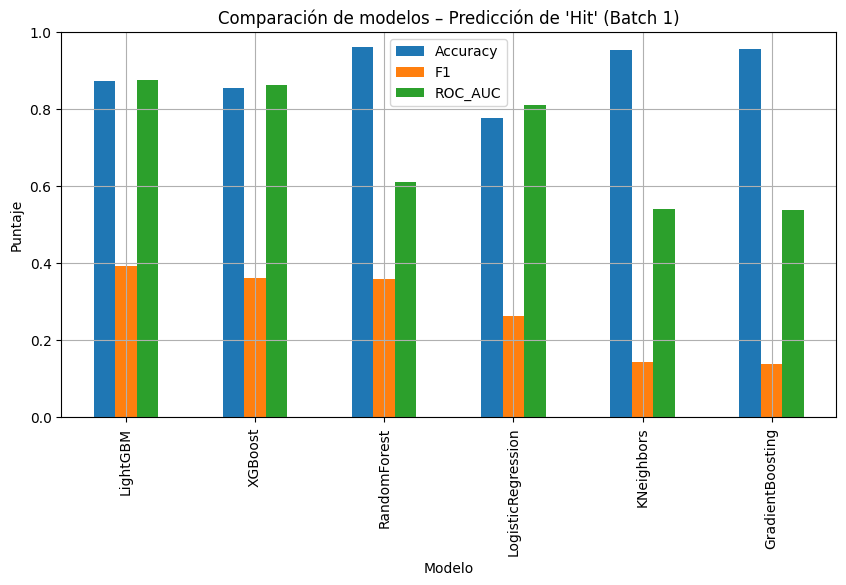

In [25]:
df_batch1 = df_resultados[df_resultados["Batch"] == "Batch_1"]
df_batch1.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 1)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

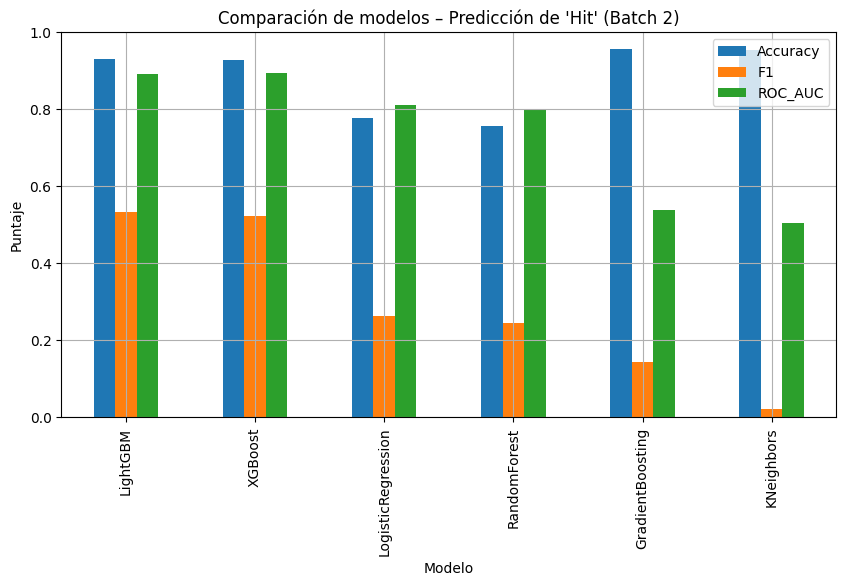

In [26]:
df_batch2 = df_resultados[df_resultados["Batch"] == "Batch_2"]
df_batch2.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 2)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Comparacion de F1-Score Bacth1 

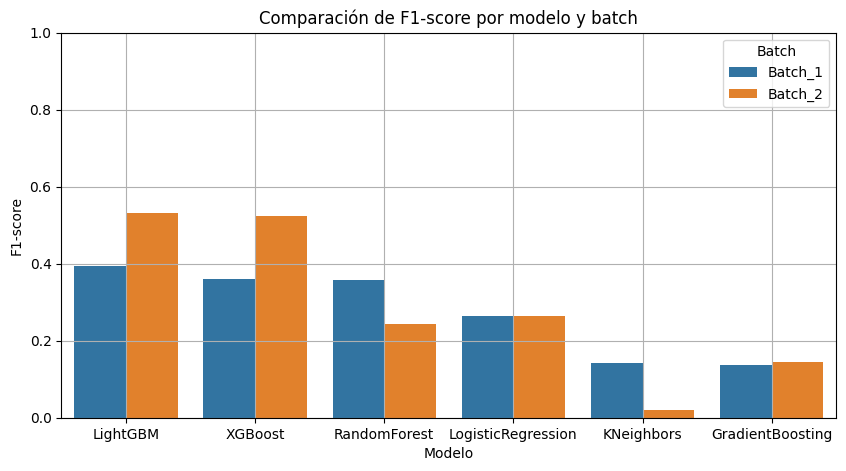

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="F1", hue="Batch")
plt.title("Comparación de F1-score por modelo y batch")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(True)
plt.show()


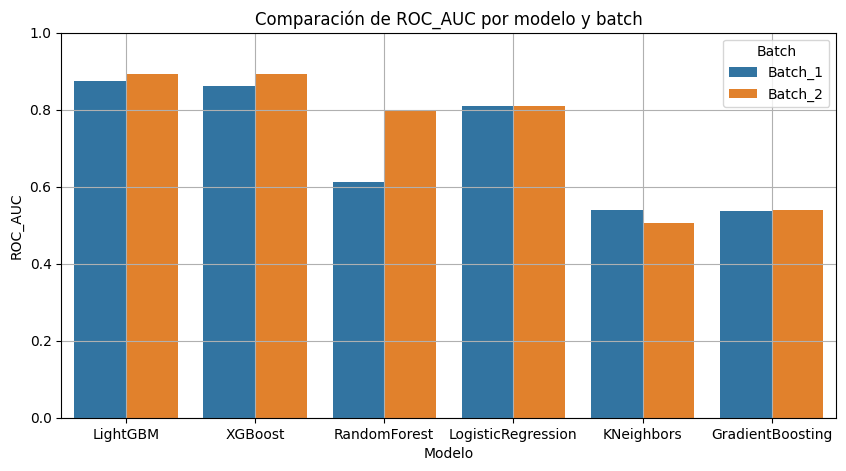

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="ROC_AUC", hue="Batch")
plt.title("Comparación de ROC_AUC por modelo y batch")
plt.ylabel("ROC_AUC")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Seleccion de Modelo

1. Mejor F1-score del Batch 2

El F1 es la métrica más importante porque el dataset está fuertemente desbalanceado (~4–5% hits).

Batch 2 — LightGBM:

F1 = 0.5690 (el más alto de todos los modelos)

Esto significa que LightGBM:

Detecta muchos más hits que otros modelos

Maneja mejor el desbalance

Tiene la mejor combinación de precision + recall para la clase HIT

Comparaciones:

Modelo	F1 (Batch_2)
LightGBM	0.569
XGBoost	0.567
RandomForest	0.449
LogisticRegression	0.415
GradientBoosting	0.394
KNN	0.355

🟢 LightGBM gana el F1-score del Batch 2.

2. AUC muy alto (segundo mejor pero casi empatado)

Batch 2:

LightGBM AUC = 0.8690

Esto indica:

Excelente capacidad para separar HIT vs NO HIT

Umbral de decisión más estable

Curva ROC muy sólida

Comparación:

Modelo	AUC (Batch_2)
LightGBM	0.869
XGBoost	0.866
LogisticRegression	0.805
RandomForest	0.676
GradientBoosting	0.632
KNN	0.618

🟢 LightGBM tiene el mejor AUC del batch (empatado virtualmente con XGBoost).